# Alicja Misiuda 
# 1.7.2024
## for time domain carving

In [4]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import time

## Load the audio file(s)

In [21]:
# Load in sounds
#flute, sr_flute = librosa.load('flute.wav')
nj, sr_nj = librosa.load('NewJeansOMG.wav')
#violin, sr_violin = librosa.load('violin.wav')
#print(sr_flute, "sr_flute sampling rate")
#print(sr_violin, "sr_violin sampling rate")

## Compute STFT and extract the magitude and phase

In [25]:
# Compute the Short-Time Fourier Transform (STFT)
#D = librosa.stft(flute)
DD = librosa.stft(nj)
# Magnitude and phase
#magnitude = np.abs(D)
#phase = np.angle(D)

## Plot the original spectrogram for reference 

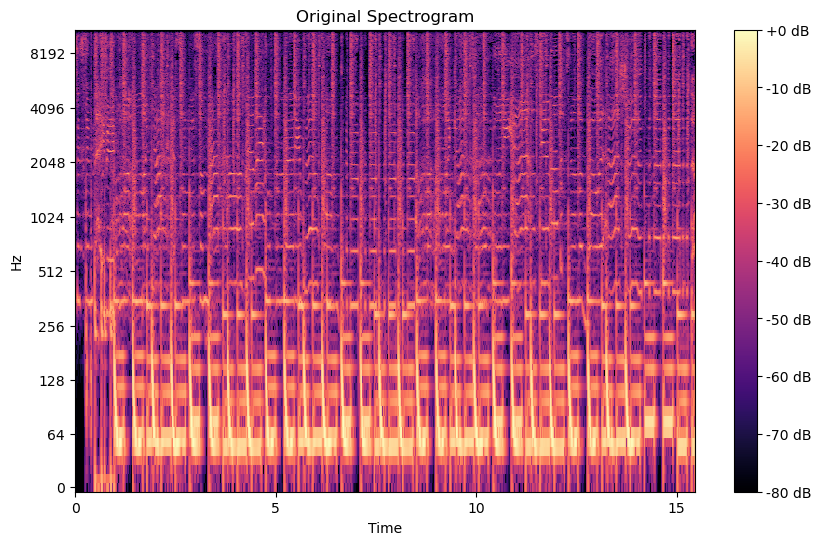

In [26]:
# # Convert the amplitude to decibels for better visualization
# D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# # Plot the spectrogram
# plt.figure(figsize=(10, 6))
# librosa.display.specshow(D_db, sr=sr_flute, x_axis='time', y_axis='log')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Original Spectrogram')
# plt.show()

# Convert the amplitude to decibels for better visualization
D_dbD = librosa.amplitude_to_db(np.abs(DD), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(D_dbD, sr=sr_nj, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Spectrogram')
plt.savefig("NewJeansOrg22.png")
xmin, xmax, ymin, ymax = plt.axis()
plt.show()

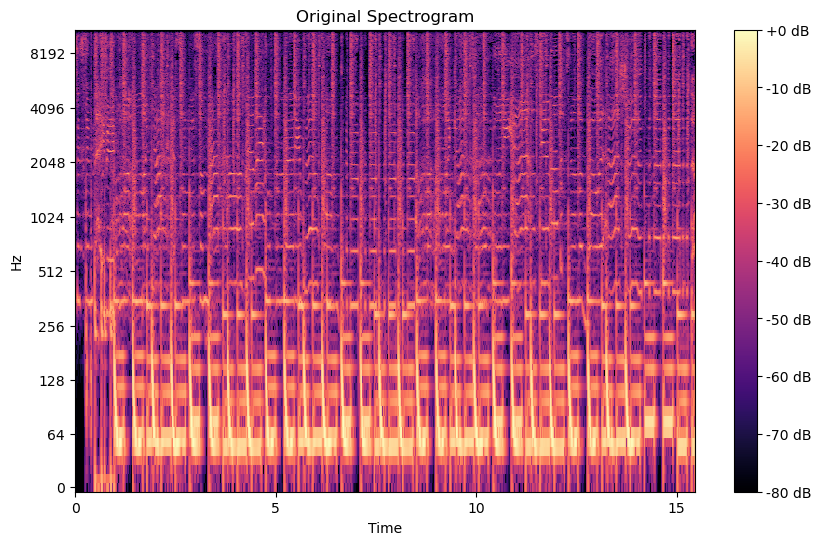

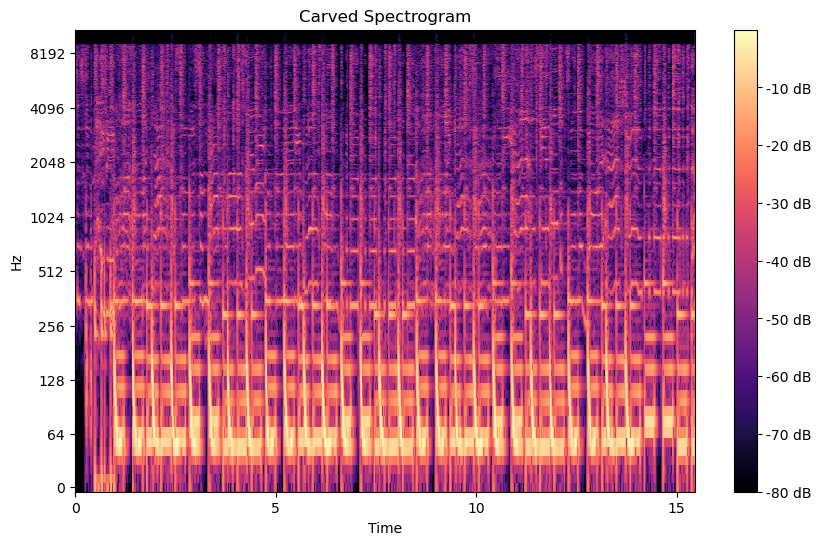

In [43]:
# Convert the amplitude to decibels for better visualization
D_dbD = librosa.amplitude_to_db(np.abs(DD), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(D_dbD, sr=sr_nj, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Spectrogram')

xmin, xmax, ymin, ymax = plt.axis()
#plt.ylim(0,1500)
plt.show()


#new_flute, sr_f = librosa.load('NewJeansOMG_vertical200.wav')
new_flute, sr_f = librosa.load('NewJeansOMG_horizontal600.wav')
D = librosa.stft(new_flute)
# Magnitude and phase
magnitude = np.abs(D)
phase = np.angle(D)
complex_spectrogram = magnitude * np.exp(1j * phase)

# Calculate spectrogram for complex spectrogram data
D_db = librosa.amplitude_to_db(np.abs(complex_spectrogram), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D_db, sr=sr_f, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Carved Spectrogram')

# Set the same axis limits as the first plot
plt.axis([xmin, xmax, ymin, ymax])
plt.savefig("NewJeans_horizontal260.png")
plt.show()

## Seam Carver Class

In [5]:
class SeamEnergyWithBackPointer:
    def __init__(self, energy, x_coordinate_in_previous_row=None):
        self.energy = energy
        self.x_coordinate_in_previous_row = x_coordinate_in_previous_row

In [6]:
def min_seam_energy(pixel_energies):
    seam_energies = []
    seam_energies.append([SeamEnergyWithBackPointer(pixel_energy) for pixel_energy in pixel_energies[0]])

    for y in range(1, len(pixel_energies)):
        pixel_energies_row = pixel_energies[y]
        seam_energies_row = []
            
        for x, pixel_energy in enumerate(pixel_energies_row):
            # Determine the range of x values to iterate over in the previous row
            x_left = max(x - 1, 0)
            x_right = min(x + 1, len(pixel_energies_row) - 1)
            x_range = range(x_left, x_right + 1)
                
            # Find the x coordinate in the previous row that yields the minimum seam energy
            min_parent_x = min(x_range, key=lambda x_i: seam_energies[y - 1][x_i].energy)
                
            # Calculate the seam energy for the current pixel
            min_seam_energy = SeamEnergyWithBackPointer(
                pixel_energy + seam_energies[y - 1][min_parent_x].energy,
                min_parent_x
            )

            seam_energies_row.append(min_seam_energy)
            
        seam_energies.append(seam_energies_row)
        
    min_energy = min(seam_energies[-1], key=lambda x: x.energy).energy
    return min_energy


def find_seam(pixel_energies):
    seam_energies = []
    seam_energies.append([SeamEnergyWithBackPointer(pixel_energy) for pixel_energy in pixel_energies[0]])
        
    for y in range(1, len(pixel_energies)):
        pixel_energies_row = pixel_energies[y]
        seam_energies_row = []
            
        for x, pixel_energy in enumerate(pixel_energies_row):
            x_left = max(x - 1, 0)
            x_right = min(x + 1, len(pixel_energies_row) - 1)
            x_range = range(x_left, x_right + 1)
                
            min_parent_x = min(x_range, key=lambda x_i: seam_energies[y - 1][x_i].energy)
                
            min_seam_energy = SeamEnergyWithBackPointer(
                pixel_energy + seam_energies[y - 1][min_parent_x].energy,
                min_parent_x
            )
                
            seam_energies_row.append(min_seam_energy)
            
        seam_energies.append(seam_energies_row)
        
    min_seam_end_x = min(range(len(seam_energies[-1])), key=lambda x: seam_energies[-1][x].energy)
        
    # Reconstruct the seam path from bottom to top
    seam = []
    seam_point_x = min_seam_end_x
    for y in range(len(seam_energies) - 1, -1, -1):
        seam.append((seam_point_x, y))
        seam_point_x = seam_energies[y][seam_point_x].x_coordinate_in_previous_row
        
    seam.reverse()  # Reverse to get coordinates from top to bottom
    return seam

#Test
ENERGIES = [
[9, 9, 0, 9, 9],
[9, 1, 9, 8, 9],
[9, 9, 9, 9, 0],
[9, 9, 9, 0, 9],
]

print("Minimum seam energy:", min_seam_energy(ENERGIES))
print("Seam path:", find_seam(ENERGIES))

Minimum seam energy: 8
Seam path: [(2, 0), (3, 1), (4, 2), (3, 3)]


In [7]:
magnitude = np.array(magnitude)
phase = np.array(phase)
print("shape of magnitude", magnitude.shape)
print("shape of phase", phase.shape)

shape of magnitude (1025, 248)
shape of phase (1025, 248)


# Perform the seam carving with n = number of seams to find + cut out

In [25]:
# Perform seam carving
n = 190
for _ in range(n):
    seam_path = find_seam(magnitude)

    new_energies = []
    new_magnitude = []
    new_phase = []

    # Remove pixels along the seam path and compress each row
    for y in range(len(magnitude)):
        new_row_magnitude = []
        new_row_phase = []
        
        seam_indices = set([x for x, _ in seam_path if _ == y])

        for x in range(len(magnitude[y])):
            if x not in seam_indices:
                new_row_magnitude.append(magnitude[y][x])
                new_row_phase.append(phase[y][x])

        new_magnitude.append(new_row_magnitude)
        new_phase.append(new_row_phase)

    magnitude = np.array(new_magnitude)
    phase = np.array(new_phase)

# Write the final edited matrix to a text file for further use
# with open('final_output_matrix.txt', 'w') as f:
#     for row in magnitude:
#         f.write(' '.join(map(str, row)) + '\n')

## Reconstruction of audio

In [26]:
print("shape of magnitude", magnitude.shape)
print("shape of phase", phase.shape)
# Reconstruct the complex spectrogram
complex_spectrogram = magnitude * np.exp(1j * phase)

reconstructed_signal = librosa.istft(complex_spectrogram)

output_filename = f'FLUTEOUTPUT{n}.wav'

# Write the reconstructed audio signal to a file using soundfile
sf.write(output_filename, reconstructed_signal, sr_flute)

shape of magnitude (1025, 58)
shape of phase (1025, 58)


## Comparison of spectrograms

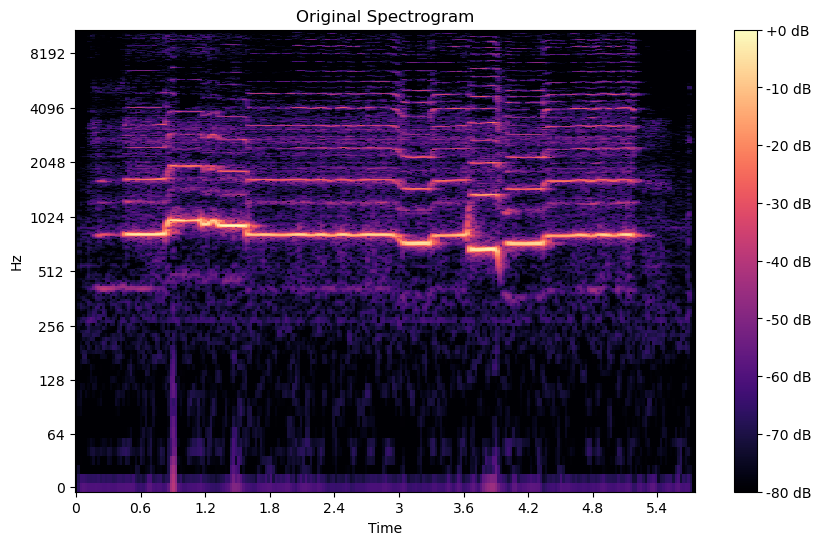

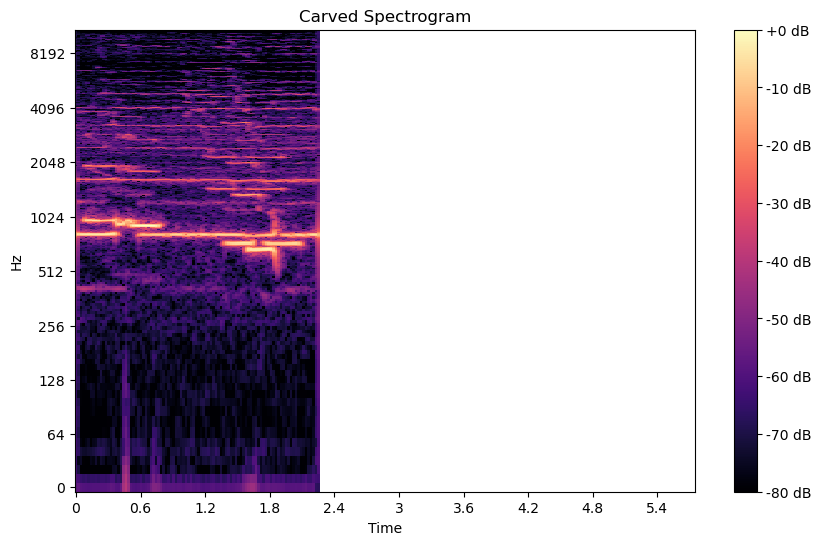

In [138]:
# Calculate spectrogram for original data
D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D_db, sr=sr_flute, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Spectrogram')

# Get axis limits of the first plot
xmin, xmax, ymin, ymax = plt.axis()

plt.show()

new_flute, sr_f = librosa.load('FLUTEOUTPUT75.wav')
D = librosa.stft(new_flute)
# Magnitude and phase
magnitude = np.abs(D)
phase = np.angle(D)
complex_spectrogram = magnitude * np.exp(1j * phase)

# Calculate spectrogram for complex spectrogram data
D_db = librosa.amplitude_to_db(np.abs(complex_spectrogram), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D_db, sr=sr_f, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Carved Spectrogram')

# Set the same axis limits as the first plot
plt.axis([xmin, xmax, ymin, ymax])

plt.show()

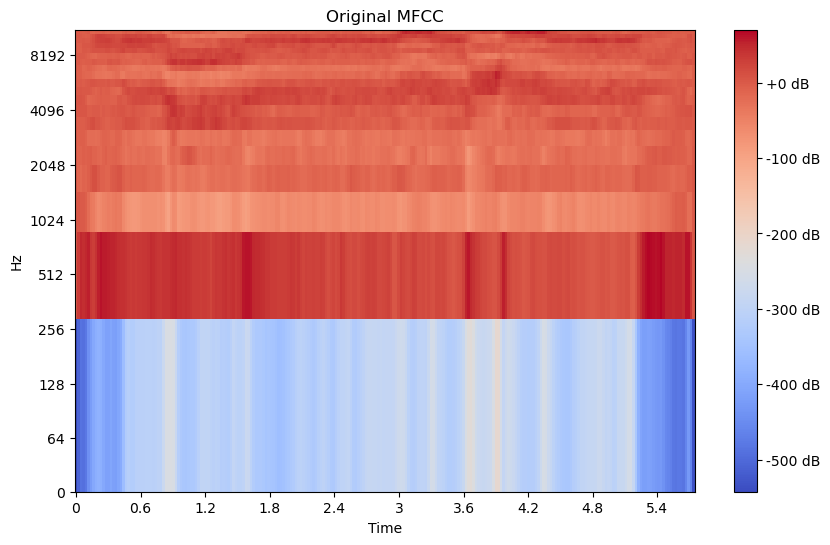

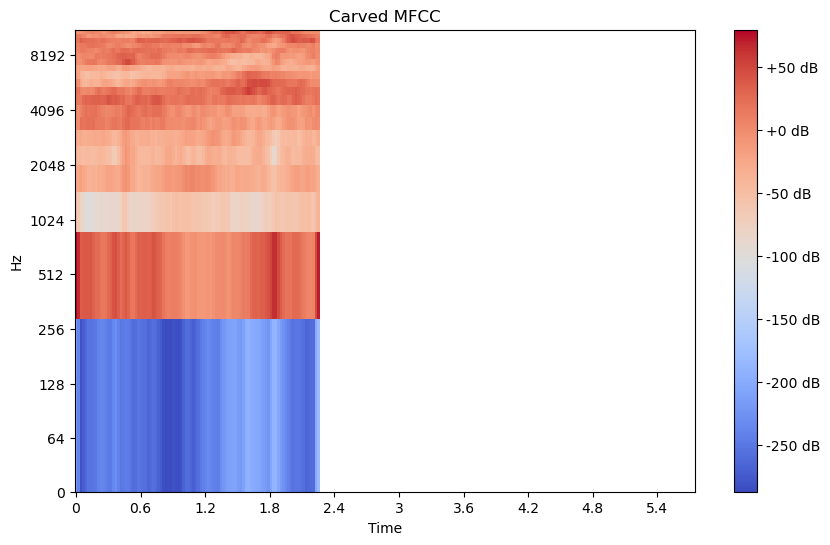

In [150]:
# Take MFCCs of sounds:
fluteMFCC = librosa.feature.mfcc(y=flute, sr=sr_flute)
flutecarvedMFCC = librosa.feature.mfcc(y=new_flute, sr=sr_f)

# # Plot MFCCs
# fig, ax = plt.subplots(1,2, figsize = (30,15))
# ax[0].set(title = 'MFCCs of Flute')
# i = librosa.display.specshow(fluteMFCC, x_axis='time', ax=ax[0])
# ax[1].set(title = 'MFCCs of Flute75')
# librosa.display.specshow(flutecarvedMFCC, x_axis='time', ax=ax[1])
# #plt.colorbar(i)

plt.figure(figsize=(10, 6))
librosa.display.specshow(fluteMFC, sr=sr_flute, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Original MFCC')

# Get axis limits of the first plot
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([0, ymax])
plt.show()

# Calculate spectrogram for complex spectrogram data
plt.figure(figsize=(10, 6))
librosa.display.specshow(flutecarvedMFCC, sr=sr_f, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Carved MFCC')

# Set the same axis limits as the first plot
plt.axis([xmin, xmax, ymin, ymax])
plt.ylim([0, ymax])
plt.show()

In [21]:
# Compute the Short-Time Fourier Transform (STFT)
D = librosa.stft(violin)

# Magnitude and phase
magnitude = np.abs(D)
phase = np.angle(D)

In [17]:
# Perform seam carving
n = 50
for _ in range(n):
    seam_path = find_seam(magnitude)

    new_energies = []
    new_magnitude = []
    new_phase = []

    # Remove pixels along the seam path and compress each row
    for y in range(len(magnitude)):
        new_row_magnitude = []
        new_row_phase = []
        
        seam_indices = set([x for x, _ in seam_path if _ == y])

        for x in range(len(magnitude[y])):
            if x not in seam_indices:
                new_row_magnitude.append(magnitude[y][x])
                new_row_phase.append(phase[y][x])

        new_magnitude.append(new_row_magnitude)
        new_phase.append(new_row_phase)

    magnitude = np.array(new_magnitude)
    phase = np.array(new_phase)

# Write the final edited matrix to a text file for further use
# with open('final_output_matrix.txt', 'w') as f:
#     for row in magnitude:
#         f.write(' '.join(map(str, row)) + '\n')

In [18]:
print("shape of magnitude", magnitude.shape)
print("shape of phase", phase.shape)
# Reconstruct the complex spectrogram
complex_spectrogram_v = magnitude * np.exp(1j * phase)

reconstructed_signal = librosa.istft(complex_spectrogram_v)

output_filename = f'VIOLINOUTPUT{n}.wav'

# Write the reconstructed audio signal to a file using soundfile
sf.write(output_filename, reconstructed_signal, sr_flute)

shape of magnitude (1025, 165)
shape of phase (1025, 165)


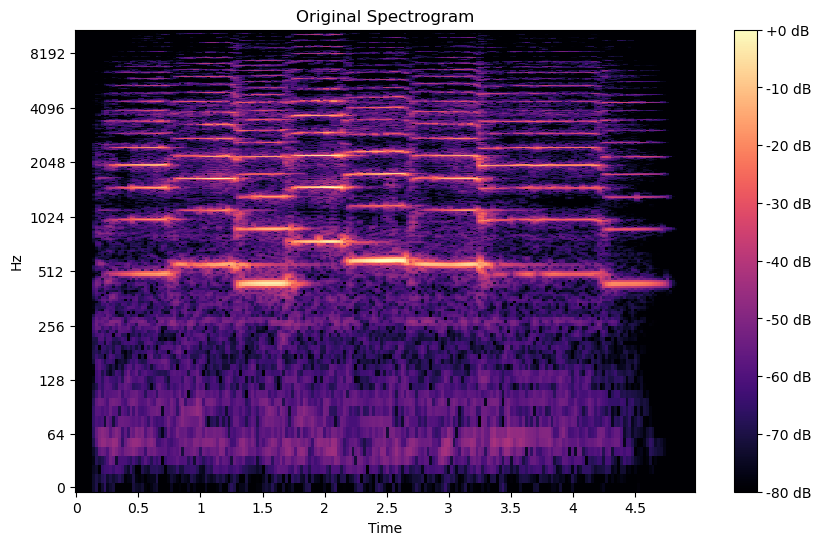

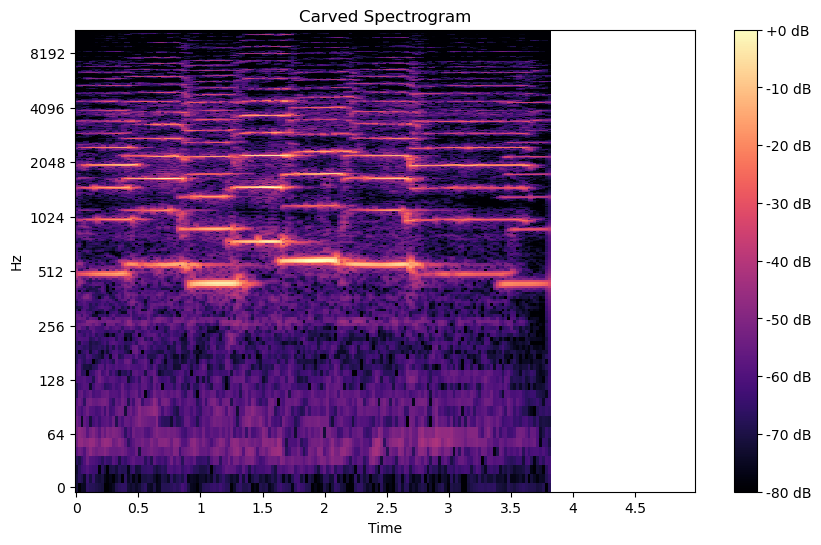

In [22]:
# Calculate spectrogram for original data
D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D_db, sr=sr_violin, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Spectrogram')

# Get axis limits of the first plot
xmin, xmax, ymin, ymax = plt.axis()

plt.show()

new_violin, sr_f = librosa.load('VIOLINOUTPUT50.wav')
D = librosa.stft(new_violin)
# Magnitude and phase
magnitude = np.abs(D)
phase = np.angle(D)
complex_spectrogram_v = magnitude * np.exp(1j * phase)

# Calculate spectrogram for complex spectrogram data
D_db = librosa.amplitude_to_db(np.abs(complex_spectrogram_v), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D_db, sr=sr_f, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Carved Spectrogram')

# Set the same axis limits as the first plot
plt.axis([xmin, xmax, ymin, ymax])

plt.show()